In [4]:
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
import subprocess
import multiprocessing
from joblib import Parallel, delayed

In [22]:
def apply_orientation(path, out_dir):
    try:
        img = nib.load(str(path))
        affine = img.affine
        axcodes = nib.aff2axcodes(affine)
        print(path, axcodes)
        canonical_img = nib.as_closest_canonical(img)
        out_path = out_dir.joinpath(path.name)
        print(out_path)
        canonical_img.to_filename(str(out_path))
    except OSError:
        print('OSError')

In [24]:
work_dir = Path('/mnt/data/rawdata/ADNI/ADNI3/ADNI/')
out_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1')

num_cores = multiprocessing.cpu_count()-5
Parallel(n_jobs=num_cores)(delayed(apply_orientation)(path, out_dir) for path in  work_dir.glob('**/ADNI*nii*'))
       

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [12]:
def vis_brain(image, slice_sel, axis_sel=1, normalize=False):
    if normalize:
        image = (image - np.mean(image))/(np.std(image))

    if axis_sel == 1:
        image = image.transpose([1, 2 , 0])
    elif axis_sel == 2:
        image = image.transpose([2, 0, 1])
    
    fig = plt.figure(figsize=(7., 7.))
    plt.imshow(image[slice_sel, : , :], cmap='gray')
    plt.axis('off')
    plt.show()

/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/brain_mni_ADNI_941_S_1202_20101111125148227_T1.nii.gz ('R', 'A', 'S')


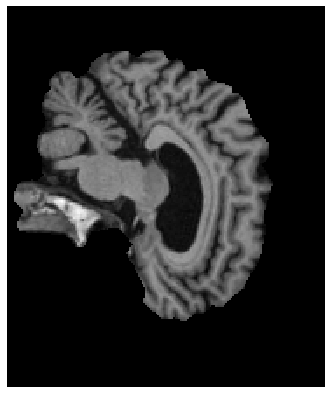

In [49]:
# check results
out_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1')

for path in out_dir.glob('**/*nii*'):
    path = out_dir.joinpath('brain_mni_ADNI_941_S_1202_20101111125148227_T1.nii.gz')
    img = nib.load(str(path))
    affine = img.affine
    axcodes = nib.aff2axcodes(affine)
    print(path, axcodes)
    vis_brain(img.get_fdata(), axis_sel=0, slice_sel=100)
    break

In [12]:
# template
mni_152_path = '/mnt/share/raheppt1/project_data/brain/MNI152_T1_1mm.nii.gz'

# Brain extraction and MNI registration

**script_preproc.sh**

       file=$1
       MNI=/mnt/share/raheppt1/project_data/brain/MNI152_T1_1mm.nii.gz
       filename=$(basename $file)
       fsl5.0-flirt -in $file -ref $MNI -out mni_$filename -dof 6
       echo $filename
       file=mni_$filename
       filename=$(basename $file)
       fsl5.0-bet  $file  brain_$filename -m
       echo $filename
    
**Parallel processing**

     find -name '*T1.nii.gz*' -exec echo {} >> inputs \;         
     cat inputs | parallel --joblog ./log -j 15 ./script_preproc.sh


# Intensity normalization

In [1]:
from intensity_normalization.normalize import zscore
    
def int_normalization(path_img, path_mask, out_dir):
    img = nib.load(str(path_img))
    mask = nib.load(str(path_mask))
    # registered image / with homogenization 
    img_normalized = zscore.zscore_normalize(img, mask=mask)
    img_normalized.to_filename(out_dir.joinpath('norm_'+path_img.name))


In [80]:
out_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/')
work_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/')

img_paths = list(work_dir.glob('**/*brain*gm*'))
img_paths.sort()
mask_paths = list(work_dir.glob('**/*brain_*pve_1*'))
mask_paths.sort()
#int_normalization(path_img, path_mask, out_dir)

for img_path, mask_path in zip(img_paths, mask_paths):
    print(img_path, mask_path)
    int_normalization(img_path, mask_path, out_dir)
    break

/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/brain_mni_IXI002_T1_gm.nii.gz /mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/brain_mni_IXI002_T1_pve_1.nii.gz


In [83]:
num_cores = multiprocessing.cpu_count()-6
Parallel(n_jobs=num_cores)(delayed(int_normalization)(img_path, mask_path, out_dir) for img_path, mask_path in zip(img_paths, mask_paths))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

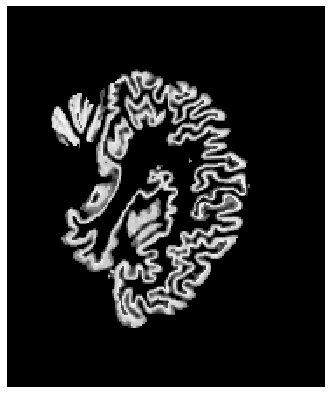

In [13]:
# Test results
image = nib.load(str(work_dir.joinpath('norm_brain_mni_IXI662_T1_gm.nii.gz')))
image = image.get_fdata()
vis_brain(image, slice_sel=50, axis_sel=0, normalize=False)

## Grey & White Matter Images

In [77]:
work_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/')

brains = list(work_dir.glob('**/*restore*nii*'))
brains.sort()
# pve_1 -> gm pve_2 -> wm
masks = list(work_dir.glob('**/*pve_2*nii*'))
masks.sort()

for brain, mask in zip(brains, masks):
    print(brain.name, mask.name)
    brain_img = sitk.ReadImage(str(brain))
    mask_img = sitk.ReadImage(str(mask))
    brain_masked = brain_img*mask_img
    sitk.WriteImage(brain_masked, str(brain.parent.joinpath(brain.name.replace('restore','wm'))))

brain_mni_IXI002_T1_restore.nii.gz brain_mni_IXI002_T1_pve_2.nii.gz
brain_mni_IXI012_T1_restore.nii.gz brain_mni_IXI012_T1_pve_2.nii.gz
brain_mni_IXI013_T1_restore.nii.gz brain_mni_IXI013_T1_pve_2.nii.gz
brain_mni_IXI014_T1_restore.nii.gz brain_mni_IXI014_T1_pve_2.nii.gz
brain_mni_IXI015_T1_restore.nii.gz brain_mni_IXI015_T1_pve_2.nii.gz
brain_mni_IXI016_T1_restore.nii.gz brain_mni_IXI016_T1_pve_2.nii.gz
brain_mni_IXI017_T1_restore.nii.gz brain_mni_IXI017_T1_pve_2.nii.gz
brain_mni_IXI019_T1_restore.nii.gz brain_mni_IXI019_T1_pve_2.nii.gz
brain_mni_IXI020_T1_restore.nii.gz brain_mni_IXI020_T1_pve_2.nii.gz
brain_mni_IXI021_T1_restore.nii.gz brain_mni_IXI021_T1_pve_2.nii.gz
brain_mni_IXI022_T1_restore.nii.gz brain_mni_IXI022_T1_pve_2.nii.gz
brain_mni_IXI023_T1_restore.nii.gz brain_mni_IXI023_T1_pve_2.nii.gz
brain_mni_IXI024_T1_restore.nii.gz brain_mni_IXI024_T1_pve_2.nii.gz
brain_mni_IXI025_T1_restore.nii.gz brain_mni_IXI025_T1_pve_2.nii.gz
brain_mni_IXI026_T1_restore.nii.gz brain_mni_IXI

brain_mni_IXI139_T1_restore.nii.gz brain_mni_IXI139_T1_pve_2.nii.gz
brain_mni_IXI140_T1_restore.nii.gz brain_mni_IXI140_T1_pve_2.nii.gz
brain_mni_IXI141_T1_restore.nii.gz brain_mni_IXI141_T1_pve_2.nii.gz
brain_mni_IXI142_T1_restore.nii.gz brain_mni_IXI142_T1_pve_2.nii.gz
brain_mni_IXI143_T1_restore.nii.gz brain_mni_IXI143_T1_pve_2.nii.gz
brain_mni_IXI144_T1_restore.nii.gz brain_mni_IXI144_T1_pve_2.nii.gz
brain_mni_IXI145_T1_restore.nii.gz brain_mni_IXI145_T1_pve_2.nii.gz
brain_mni_IXI146_T1_restore.nii.gz brain_mni_IXI146_T1_pve_2.nii.gz
brain_mni_IXI148_T1_restore.nii.gz brain_mni_IXI148_T1_pve_2.nii.gz
brain_mni_IXI150_T1_restore.nii.gz brain_mni_IXI150_T1_pve_2.nii.gz
brain_mni_IXI151_T1_restore.nii.gz brain_mni_IXI151_T1_pve_2.nii.gz
brain_mni_IXI153_T1_restore.nii.gz brain_mni_IXI153_T1_pve_2.nii.gz
brain_mni_IXI154_T1_restore.nii.gz brain_mni_IXI154_T1_pve_2.nii.gz
brain_mni_IXI156_T1_restore.nii.gz brain_mni_IXI156_T1_pve_2.nii.gz
brain_mni_IXI157_T1_restore.nii.gz brain_mni_IXI

brain_mni_IXI276_T1_restore.nii.gz brain_mni_IXI276_T1_pve_2.nii.gz
brain_mni_IXI277_T1_restore.nii.gz brain_mni_IXI277_T1_pve_2.nii.gz
brain_mni_IXI278_T1_restore.nii.gz brain_mni_IXI278_T1_pve_2.nii.gz
brain_mni_IXI279_T1_restore.nii.gz brain_mni_IXI279_T1_pve_2.nii.gz
brain_mni_IXI280_T1_restore.nii.gz brain_mni_IXI280_T1_pve_2.nii.gz
brain_mni_IXI282_T1_restore.nii.gz brain_mni_IXI282_T1_pve_2.nii.gz
brain_mni_IXI284_T1_restore.nii.gz brain_mni_IXI284_T1_pve_2.nii.gz
brain_mni_IXI285_T1_restore.nii.gz brain_mni_IXI285_T1_pve_2.nii.gz
brain_mni_IXI286_T1_restore.nii.gz brain_mni_IXI286_T1_pve_2.nii.gz
brain_mni_IXI287_T1_restore.nii.gz brain_mni_IXI287_T1_pve_2.nii.gz
brain_mni_IXI288_T1_restore.nii.gz brain_mni_IXI288_T1_pve_2.nii.gz
brain_mni_IXI289_T1_restore.nii.gz brain_mni_IXI289_T1_pve_2.nii.gz
brain_mni_IXI290_T1_restore.nii.gz brain_mni_IXI290_T1_pve_2.nii.gz
brain_mni_IXI291_T1_restore.nii.gz brain_mni_IXI291_T1_pve_2.nii.gz
brain_mni_IXI292_T1_restore.nii.gz brain_mni_IXI

brain_mni_IXI409_T1_restore.nii.gz brain_mni_IXI409_T1_pve_2.nii.gz
brain_mni_IXI410_T1_restore.nii.gz brain_mni_IXI410_T1_pve_2.nii.gz
brain_mni_IXI411_T1_restore.nii.gz brain_mni_IXI411_T1_pve_2.nii.gz
brain_mni_IXI412_T1_restore.nii.gz brain_mni_IXI412_T1_pve_2.nii.gz
brain_mni_IXI413_T1_restore.nii.gz brain_mni_IXI413_T1_pve_2.nii.gz
brain_mni_IXI414_T1_restore.nii.gz brain_mni_IXI414_T1_pve_2.nii.gz
brain_mni_IXI415_T1_restore.nii.gz brain_mni_IXI415_T1_pve_2.nii.gz
brain_mni_IXI416_T1_restore.nii.gz brain_mni_IXI416_T1_pve_2.nii.gz
brain_mni_IXI417_T1_restore.nii.gz brain_mni_IXI417_T1_pve_2.nii.gz
brain_mni_IXI418_T1_restore.nii.gz brain_mni_IXI418_T1_pve_2.nii.gz
brain_mni_IXI419_T1_restore.nii.gz brain_mni_IXI419_T1_pve_2.nii.gz
brain_mni_IXI420_T1_restore.nii.gz brain_mni_IXI420_T1_pve_2.nii.gz
brain_mni_IXI422_T1_restore.nii.gz brain_mni_IXI422_T1_pve_2.nii.gz
brain_mni_IXI423_T1_restore.nii.gz brain_mni_IXI423_T1_pve_2.nii.gz
brain_mni_IXI424_T1_restore.nii.gz brain_mni_IXI

brain_mni_IXI541_T1_restore.nii.gz brain_mni_IXI541_T1_pve_2.nii.gz
brain_mni_IXI542_T1_restore.nii.gz brain_mni_IXI542_T1_pve_2.nii.gz
brain_mni_IXI543_T1_restore.nii.gz brain_mni_IXI543_T1_pve_2.nii.gz
brain_mni_IXI544_T1_restore.nii.gz brain_mni_IXI544_T1_pve_2.nii.gz
brain_mni_IXI546_T1_restore.nii.gz brain_mni_IXI546_T1_pve_2.nii.gz
brain_mni_IXI547_T1_restore.nii.gz brain_mni_IXI547_T1_pve_2.nii.gz
brain_mni_IXI548_T1_restore.nii.gz brain_mni_IXI548_T1_pve_2.nii.gz
brain_mni_IXI549_T1_restore.nii.gz brain_mni_IXI549_T1_pve_2.nii.gz
brain_mni_IXI550_T1_restore.nii.gz brain_mni_IXI550_T1_pve_2.nii.gz
brain_mni_IXI551_T1_restore.nii.gz brain_mni_IXI551_T1_pve_2.nii.gz
brain_mni_IXI552_T1_restore.nii.gz brain_mni_IXI552_T1_pve_2.nii.gz
brain_mni_IXI553_T1_restore.nii.gz brain_mni_IXI553_T1_pve_2.nii.gz
brain_mni_IXI554_T1_restore.nii.gz brain_mni_IXI554_T1_pve_2.nii.gz
brain_mni_IXI555_T1_restore.nii.gz brain_mni_IXI555_T1_pve_2.nii.gz
brain_mni_IXI556_T1_restore.nii.gz brain_mni_IXI

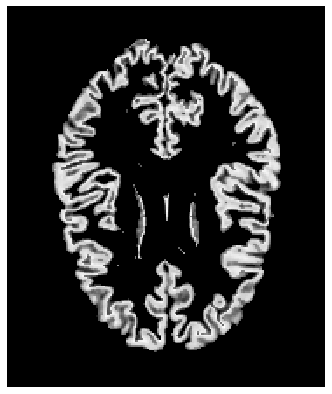

In [14]:
work_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/')

brains = list(work_dir.glob('**/*gm*nii*'))
for brain in list(brains):
    brain_img = sitk.ReadImage(str(brain))
    vis_brain(sitk.GetArrayFromImage(brain_img), slice_sel=100, axis_sel=0, normalize=False)
    break

## Intensity normalization (FCM)

In [5]:
from intensity_normalization.normalize import fcm
import intensity_normalization

In [6]:
out_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/')
work_dir = Path('/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1/')

In [8]:
img_paths = list(work_dir.glob('**/*brain_mni*T1.nii*'))
img_paths.sort()
mask_paths = list(work_dir.glob('**/*brain*mask.nii*'))
mask_paths.sort()
#int_normalization(path_img, path_mask, out_dir)

def fcm_normalization(path_img, path_mask, out_dir):
    img = nib.load(str(path_img))
    mask = nib.load(str(path_mask))
    wm_mask = fcm.find_wm_mask(img, mask, threshold=0.8)
    normalized_img = fcm.fcm_normalize(img, wm_mask, norm_value=1)
    normalized_img.to_filename(out_dir.joinpath('fcmnorm_'+path_img.name))
    wm_mask.to_filename(out_dir.joinpath('wmfcm_'+path_img.name))
    return normalized_img
    
#tep = 0
#for img_path, mask_path in zip(img_paths, mask_paths):
#    print(img_path, mask_path)
#    fcm_normalization(img_path, mask_path, out_dir)
#    vis_brain(normalized_img.get_fdata(), slice_sel=100, axis_sel=0, normalize=False)
 #   intensity_normalization.plot.hist.hist(img)
 #   intensity_normalization.plot.hist.hist(normalized_img)
 #   break

In [9]:
num_cores = multiprocessing.cpu_count()-10
Parallel(n_jobs=num_cores)(delayed(fcm_normalization)(img_path, mask_path, out_dir) for img_path, mask_path in zip(img_paths, mask_paths))

 ...]